# Polynomial Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy, math
import pandas as pd

In [2]:
def zscore_normal(x):
        mu = np.mean(x,axis=0)
        sigma = np.std(x,axis=0)
        x_norm = (x-mu)/sigma

        return (x_norm)
        
def mean_normal(x):
        mu = np.mean(x,axis=0)
        x_norm = (x-mu)/(np.max(x)-np.min(x))
                
        return (x_norm)

def r2_score(y,y_pred):
        y_avg = np.average(y, axis=0)
        num = 0
        den = 0
        for i in range(y.shape[0]):
                num = num + (y[i]-y_pred[i])**2
                den = den + (y[i]-y_avg)**2
        return (1 - (num/den))

def accuracy(y_pred, y_true):
        c = 0
        for i in range (y_true.shape[0]):
                if y_true[i] == y_pred[i]:
                        c += 1
                
        return (c/y_true.shape[0])
        
def plot_cost(Cost_list, iterations):
        t = np.arange(0, iterations)
        plt.plot(t, Cost_list)
        plt.show

In [3]:
class PolynomialRegression:

    def __init__(self,x,w,b,l,alpha,iterations,show_progress = False):
        self.x = x
        self.w = w
        self.b = b
        self.l = l
        self.alpha = alpha
        self.iterations = iterations
        self.show_progress = show_progress

    def features(self,degrees,x):
        m = x.shape[1]
        data = pd.DataFrame(np.zeros((x.shape[0],degrees*m)))
        
        for j in range(m):   
            for i in range(1,degrees+1):  
                data.iloc[:,j+((i-1)*m)] = (x[:,j]**(i)).reshape(-1,1)
        x_poly = np.array(data.values.tolist())
        return x_poly

    def features_interacting(self,degrees,x):
        m = x.shape[1]
        data = pd.DataFrame(np.zeros((x.shape[0],(degrees+2)*m)))
        
        for j in range(m):   
            for i in range(1,degrees+3):  
                if i == degrees+1:
                    data.iloc[:,j+((i-1)*m)] = (x[:,j]*x[:,m-j-1]).reshape(-1,1)
                elif i == degrees+2:
                    data.iloc[:,j+((i-1)*m)] = ((x[:,j]**(degrees-1))*x[:,m-j-1]).reshape(-1,1)
                else:    
                    data.iloc[:,j+((i-1)*m)] = (x[:,j]**(i)).reshape(-1,1)
        x_poly = np.array(data.values.tolist())
        return x_poly


    def cost(self,y,w,b,l):
        m = self.x.shape[0]
        f_wb = np.dot(self.x,w) + b
        cost = (np.sum(np.square(f_wb-y))/(2*m)) + (l/(2*m)) * np.sum(np.square(w))
        return cost
    
    def grad_fn (self,y,w,b,l):
        m = self.x.shape[0]
        f_wb = np.dot(self.x, w) + b
        err = f_wb - y
        dj_dw = (np.dot(err, self.x) / m) + (l/m)*w
        dj_db = np.sum(err) / m
        return dj_dw, dj_db
    
    def grad_descent(self,y):
        J_history = []
        l = self.l
        _w = copy.deepcopy(self.w)
        _b = self.b

        for i in range(self.iterations):

            dj_dw,dj_db=self.grad_fn(y,_w,_b,l)

            _w = _w - self.alpha * dj_dw
            _b = _b - self.alpha * dj_db

            if i<100000:
                J_history.append(self.cost(y,_w,_b,l))

            if self.show_progress and i% math.ceil(self.iterations / 10) == 0:
                print(f"Iteration {i:4d}: Cost {J_history[-1]:8.5f}   ")
        
        return _w, _b, J_history
    
    def predict(self,x,w,b):
        return (np.dot(x,w)+b)
    

def multinomial_features1(x, n):
    '''This function only generates the multinomial expansion of nth degree'''
    m = x.shape[0]

    terms = math.comb(n + 2, 2)
    features = np.zeros((m, terms + 3))

    for i in range(m):
        x1, x2, x3 = x[i]
        terms = [x1**m1 * x2**m2 * x3**m3 for m1 in range(n + 1) for m2 in range(n + 1) for m3 in range(n + 1) if m1 + m2 + m3 == n]
        features[i, :len(terms)] = terms
        features[i, -3:] = [x1, x2, x3]
    return features


def multinomial_features2(x, n):
    '''This function generates the multinomial expansion for all degrees =< n'''
    m = x.shape[0]
    features_count = sum([math.comb(n + i - 1, i) for i in range(1, n + 2)])
    
    features = np.zeros((m, features_count))

    for i in range(m):
        current_index = 0

        for j in range(x.shape[1]):
            features[i, current_index] = x[i, j]
            current_index += 1

        for d in range(2, n + 1):
            for m1 in range(d + 1):
                for m2 in range(d - m1 + 1):
                    m3 = d - m1 - m2
                    features[i, current_index] = x[i, 0]**m1 * x[i, 1]**m2 * x[i, 2]**m3
                    current_index += 1

    return features

In [4]:
file_path = 'Polynomialdata_train.csv'
df = pd.read_csv(file_path, dtype='float64')

y = df.iloc[:, 0].values
x = df.iloc[:, 1:].values

x_train = x[0:40000]
y_train = y[0:40000].reshape(-1,)

In [5]:
print("Shape of training set input: ", x_train.shape)
print("Shape of training set output: ", y_train.shape)

Shape of training set input:  (40000, 3)
Shape of training set output:  (40000,)


In [6]:
degree = 6

initial_w=np.zeros([math.comb(degree+2, 2)+3])
initial_b=0
iterations = 10000
alpha = 0.1
l = 10e-12

x_train = multinomial_features1(x_train,degree)
x_train = zscore_normal(x_train)

In [7]:
print(x_train.shape) #shape of x_train after feature engineering

(40000, 31)


In [8]:
polynomial_model = PolynomialRegression(x_train,initial_w,initial_b,l,alpha,iterations, show_progress=True)

w_final, b_final, J_hist = polynomial_model.grad_descent(y_train)

y_pred = polynomial_model.predict(x_train,w_final,b_final)

Iteration    0: Cost 44454117205055.71875   
Iteration 1000: Cost 651.93922   
Iteration 2000: Cost 475.22681   
Iteration 3000: Cost 475.22681   
Iteration 4000: Cost 475.22681   
Iteration 5000: Cost 475.22681   
Iteration 6000: Cost 475.22681   
Iteration 7000: Cost 475.22681   
Iteration 8000: Cost 475.22681   
Iteration 9000: Cost 475.22681   


In [9]:
r2score = r2_score(y_train,y_pred)
print("R2 Score for train data: ",r2score)

R2 Score for train data:  0.9999999999920538


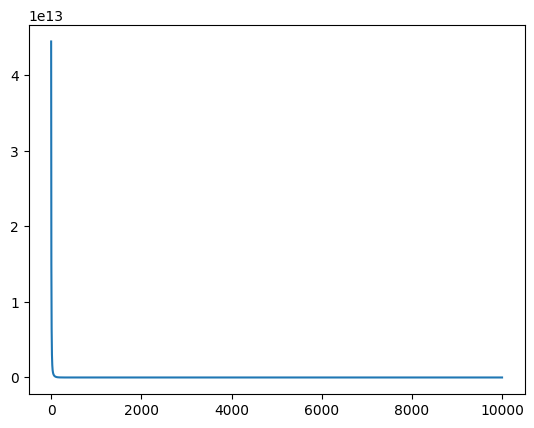

In [10]:
plot_cost(J_hist, iterations)

In [11]:
x_cv=x[40000:]
y_cv=y[40000:]
x_cv = np.array(x_cv,dtype=float)
y_cv = np.array(y_cv,dtype=float)
y_cv = y_cv.transpose()
x_cv = zscore_normal(x_cv)
x_cv = multinomial_features1(x_cv,degree)
x_cv = zscore_normal(x_cv)

In [12]:
print("Shape of cross validation set input: ", x_cv.shape)
print("Shape of cross validation set output: ", y_cv.shape)

Shape of cross validation set input:  (10000, 31)
Shape of cross validation set output:  (10000,)


In [13]:
y_cv_pred = polynomial_model.predict(x_cv, w_final, b_final)
print("R2 Score for cross validation data: ",r2_score(y_cv,y_cv_pred))

R2 Score for cross validation data:  0.9833029858149778


In [14]:
print(f"W found by linear regression: {w_final}")

W found by linear regression: [8.80970415e+06 9.62026577e+05 9.57528476e+04 7.88415199e+03
 5.13071633e+02 2.60595701e+01 5.66501503e-01 6.41754756e+06
 5.75298110e+05 5.54060706e+04 4.27221291e+03 2.60792851e+02
 1.04592314e+01 3.17399341e+06 3.01417054e+05 2.67278568e+04
 1.93528810e+03 8.94895111e+01 1.26472083e+06 1.22094936e+05
 1.01018251e+04 5.54877448e+02 4.19537576e+05 3.94148021e+04
 2.59686505e+03 1.25551474e+05 1.06832777e+04 3.16176952e+04
 1.66628657e+01 1.65181965e-01 1.13754715e-01]


In [15]:
print(f"B found by linear regression: {b_final}")

B found by linear regression: 1745315.69010339


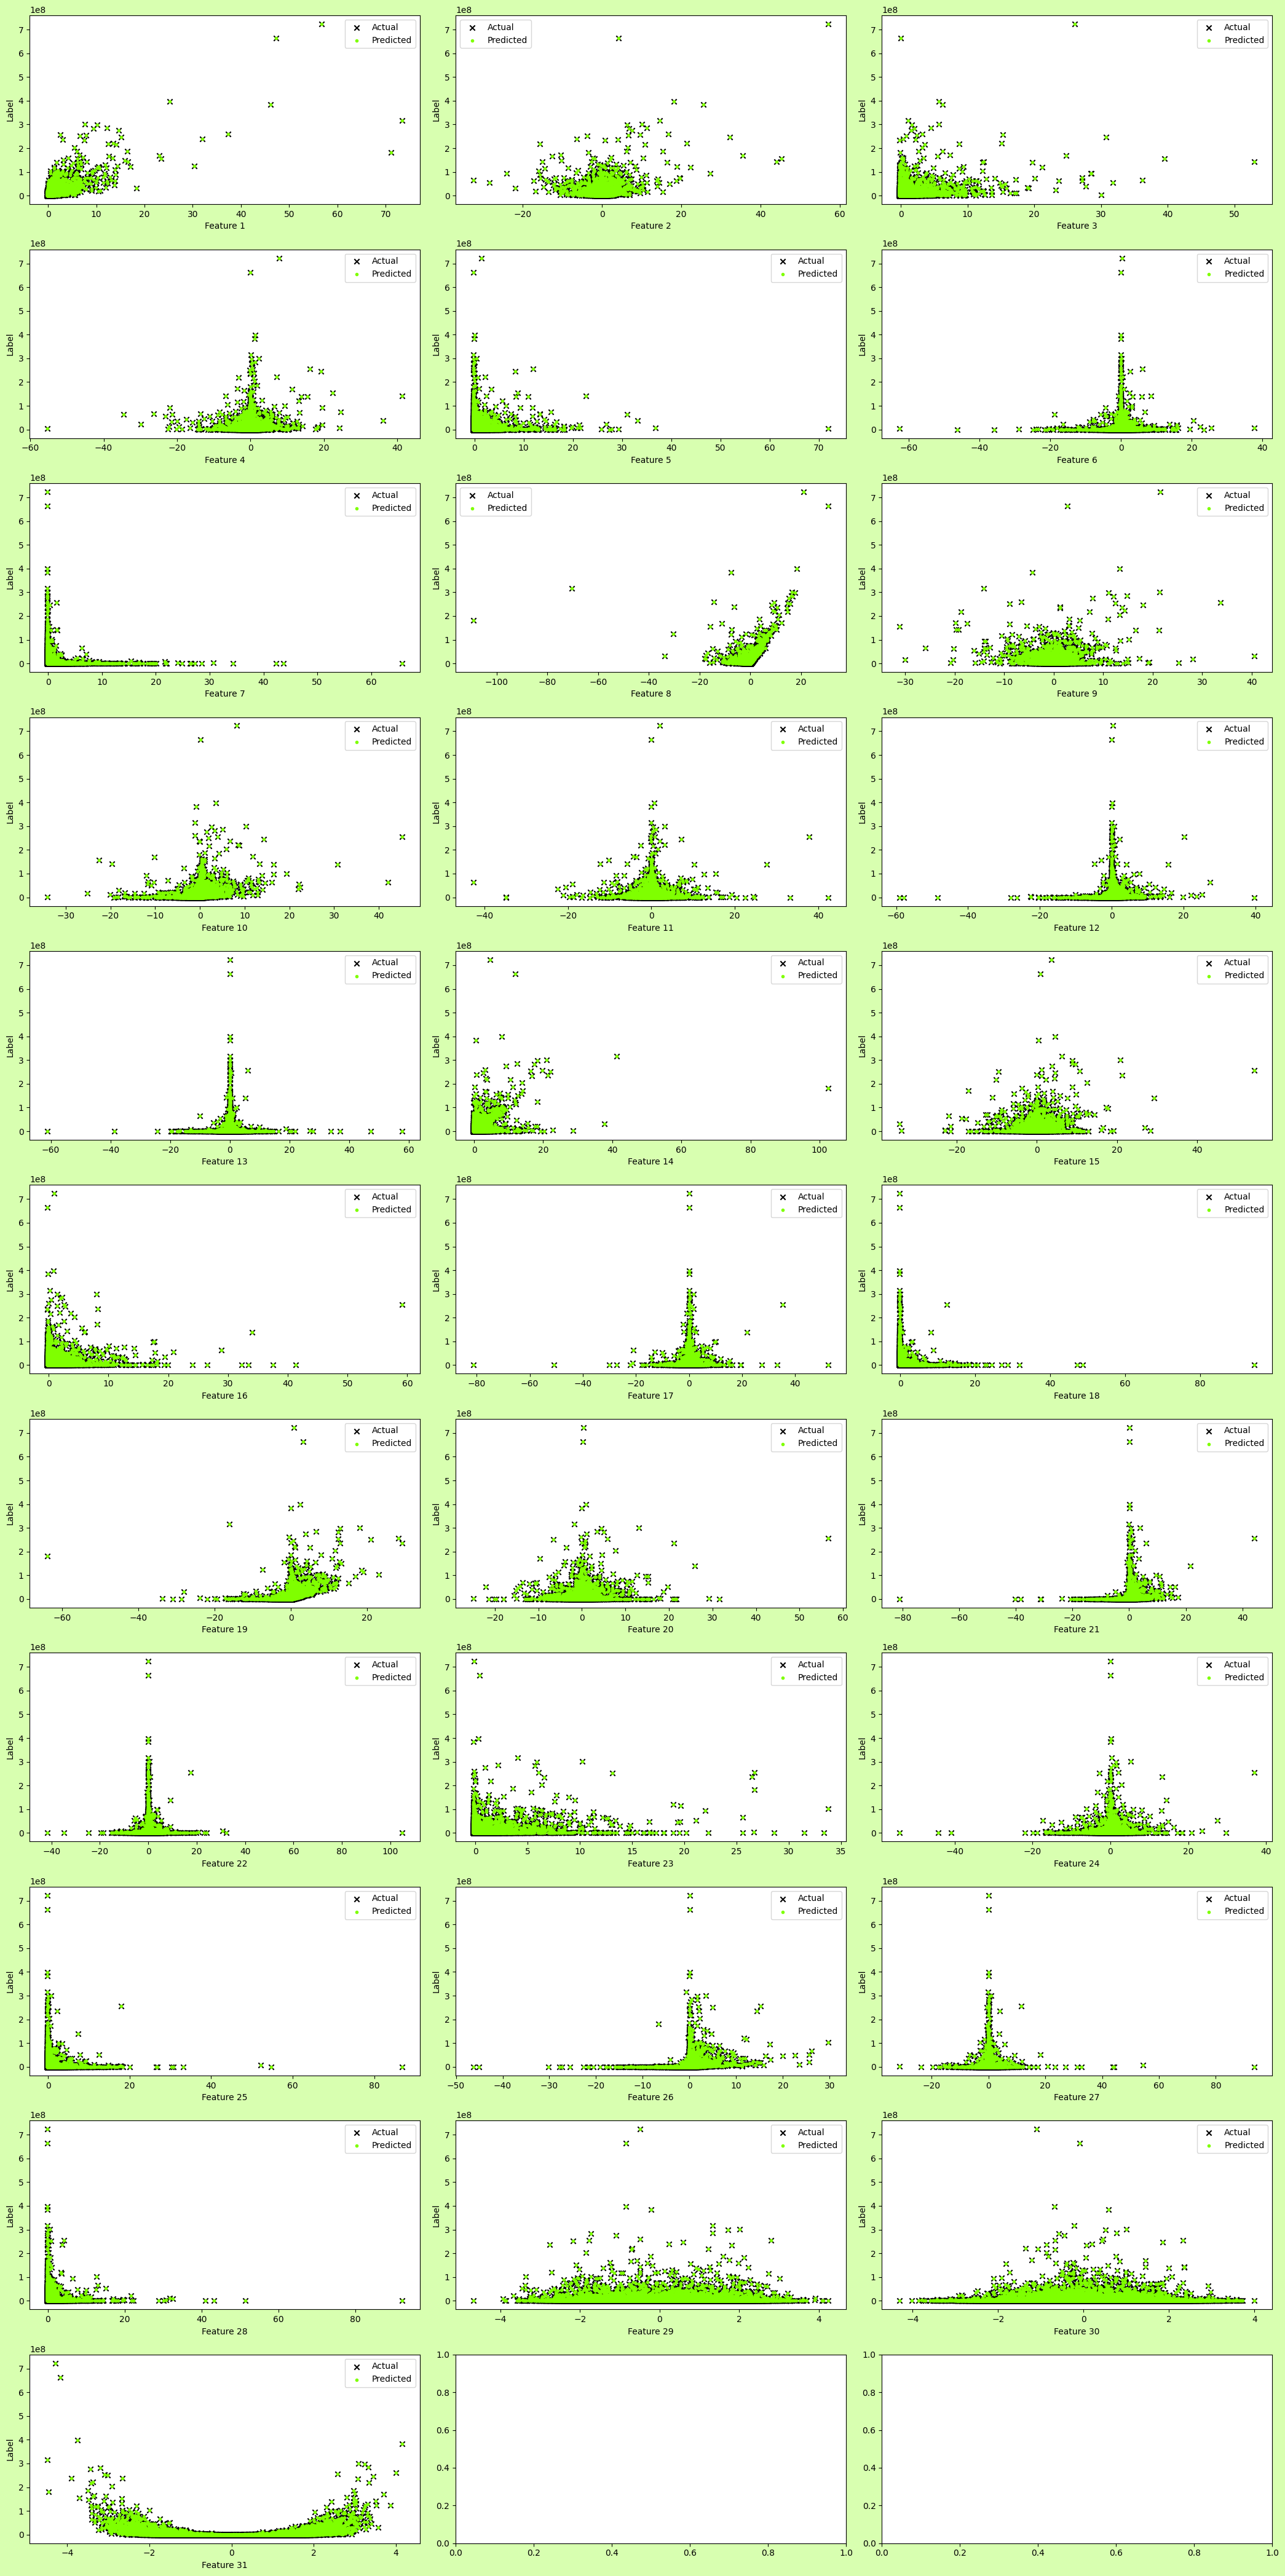

In [16]:
fig, axs = plt.subplots(11, 3, figsize=(21, 42))
fig.set_facecolor('#d8ffb0')

for i in range(0, x_train.shape[1]):
    axs[i // 3, i % 3].scatter(x_train[:, i], y_train, marker='x', c='#000000', label='Actual')
    axs[i // 3, i % 3].scatter(x_train[:, i], y_pred, marker='.', c='#7fff00', label='Predicted')
    axs[i // 3, i % 3].set_xlabel('Feature ' + str(i+1))
    axs[i // 3, i % 3].set_ylabel('Label')
    axs[i // 3, i % 3].legend()

plt.tight_layout()

plt.show()

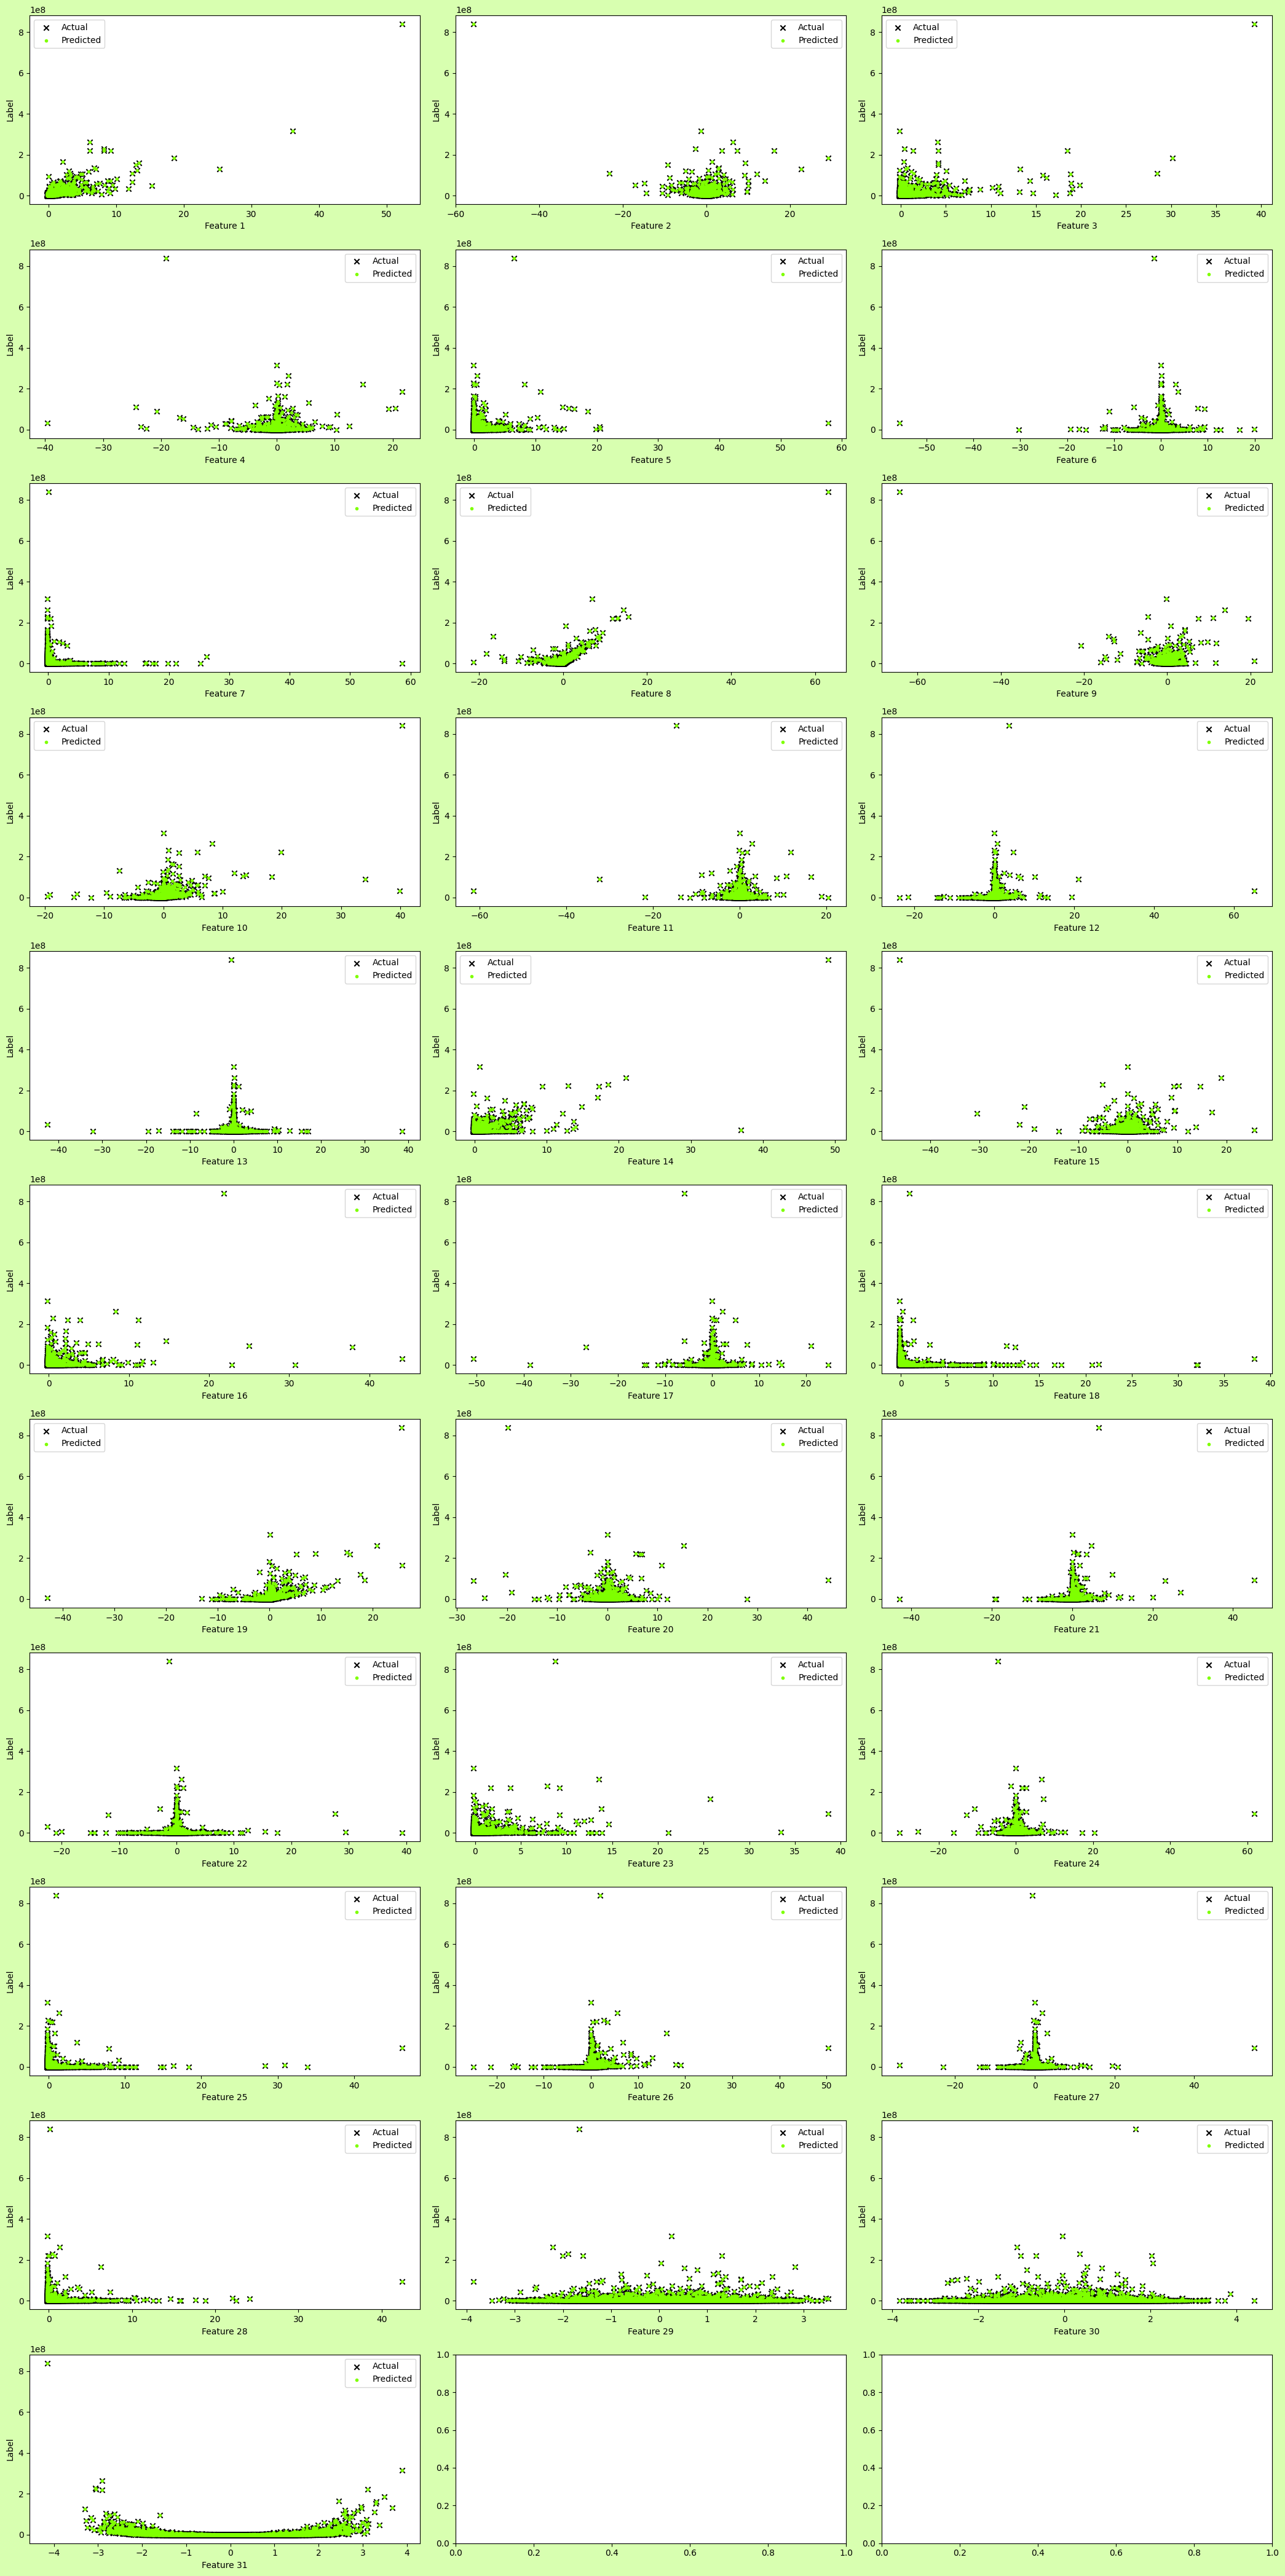

In [17]:
fig, axs = plt.subplots(11, 3, figsize=(21,42))
fig.set_facecolor('#d8ffb0')

for i in range(0, x_cv.shape[1]):
    axs[i // 3, i % 3].scatter(x_cv[:, i], y_cv, marker='x', c='#000000', label='Actual')
    axs[i // 3, i % 3].scatter(x_cv[:, i], y_cv, marker='.', c='#7fff00', label='Predicted')
    axs[i // 3, i % 3].set_xlabel('Feature ' + str(i+1))
    axs[i // 3, i % 3].set_ylabel('Label')
    axs[i // 3, i % 3].legend()

plt.tight_layout()

plt.show()

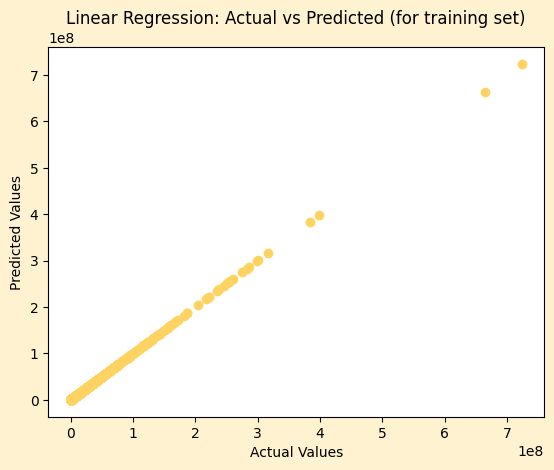

In [18]:
fig = plt.figure(facecolor='#fff2d0')

plt.scatter(y_train, y_pred, c = '#ffd361')


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted (for training set)")
plt.show()

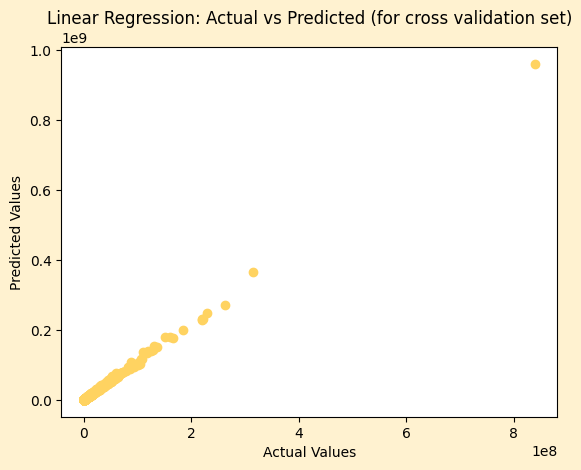

In [19]:
fig = plt.figure(facecolor='#fff2d0')

plt.scatter(y_cv, y_cv_pred, c = '#ffd361')


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted (for cross validation set)")
plt.show()

In [20]:
file_path = 'polynomialdata_test.csv'
df = pd.read_csv(file_path, dtype='float64')

test_id = df.iloc[:, 0].values
x_test = df.iloc[:, 1:].values

x_test = np.array(x_test, dtype=float)
x_test = multinomial_features1(x_test, degree)
x_test = zscore_normal(x_test)

In [21]:
print("Shape of test set input: ", x_test.shape)

Shape of test set input:  (10000, 31)


In [22]:
y_test = polynomial_model.predict(x_test, w_final, b_final)

In [23]:
print(y_test)

[ 253944.14630279  596281.69159755 -419755.1321292  ...  632921.51670675
 -353991.32102576 -441819.78213808]


In [24]:
output = np.array((test_id, y_test))
print(output)

[[  16588.           17513.           14448.         ...   17741.
    18381.           12054.        ]
 [ 253944.14630279  596281.69159755 -419755.1321292  ...  632921.51670675
  -353991.32102576 -441819.78213808]]


In [25]:
output_data = {'ID': output[0], 'Output': output[1]}

output_df = pd.DataFrame(output_data)

output_csv_path = 'Polynomial Regression Output.csv'
output_df.to_csv(output_csv_path, index = False)